In [1]:
import pandas as pd
from sklearn import linear_model
import csv
import seaborn as sns
from eyeInfo import EyeInfo
import numpy as np

In [2]:
# coloque o prefixo do nome na variavel prefix para analisar
prefix = 'mascara'
# quantidade de dados por ponto de calibração
subset_size = 50
# divide os clusters em cores
is_subset = True
# determina se o grafico deve ou nao ficar travado nas dimensoes upper_lim_x e upper_lim_y
lock_plot = False
# edite os calib points para ficar igual o front
display_train_data = True
display_predict_data = True
display_cost = True
display_prediction = True
calib_points = [
    { "x": 200, "y": 200, 'order':1 },
    { "x": 1672, "y": 200, 'order':2 },
    { "x": 936, "y": 472, 'order':3 },
    { "x": 200, "y": 744, 'order':4 },
    { "x": 1672, "y": 744, 'order':5 }
]

In [3]:
output = './csv/output/output.csv'
output_right = './csv/output/outright.csv'
output_left = './csv/output/outleft.csv'
train_input = f'./csv/data/{prefix}_fixed_train_data.csv'
predict_input = f'./csv/data/{prefix}_predict_train_data.csv'

fieldnames = ['screen_x', 'screen_y','left_iris_x','left_iris_y','right_iris_x','right_iris_y']
fieldnames_left = ['screen_x', 'screen_y', 'left_iris_x','left_iris_y']
fieldnames_rigth = ['screen_x', 'screen_y', 'right_iris_x','right_iris_y']

palette = {
    'calib_df': 'black',
    'first': 'blue',
    'second': 'red',
    'third': 'green',
    'fourth': 'yellow',
    'fifth':'lightgreen'
}

legend_dict = {
    palette['first']: 'Cluster 1',
    palette['second']: 'Cluster 2',
    palette['third']: 'Cluster 3',
    palette['fourth']: 'Cluster 4',
    palette['fifth']: 'Cluster 5',
}

In [4]:
def train_to_validate_calib(output, fieldnames, isLeft, isRight):
    dataset_train_path = train_input
    dataset_predict_path = predict_input
    data = pd.read_csv(dataset_train_path)
    if isLeft:
        X = data[[ 'left_iris_x', 'left_iris_y']]
        y = data[['point_x', 'point_y']]
    elif isRight:
        X = data[[ 'right_iris_x', 'right_iris_y']]
        y = data[['point_x', 'point_y']]
    else:   
        X = data[['left_iris_x', 'left_iris_y', 'right_iris_x', 'right_iris_y']]
        y = data[['point_x', 'point_y']]

    model = linear_model.LinearRegression()
    model.fit(X, y)
    dados_teste = pd.read_csv(dataset_predict_path)
    if isLeft:
        dados_teste.drop(['right_iris_x', 'right_iris_y'], axis=1, inplace=True)
        eye_positions = dados_teste[['left_iris_x', 'left_iris_y']].values
    elif isRight:
        dados_teste.drop(['left_iris_x', 'left_iris_y'], axis=1, inplace=True)
        eye_positions = dados_teste[['right_iris_x', 'right_iris_y']].values
    else:
        eye_positions = dados_teste[['left_iris_x', 'left_iris_y', 'right_iris_x', 'right_iris_y']].values

    previsoes = model.predict(dados_teste)
    combined_predictions = np.concatenate((previsoes, eye_positions), axis=1)

    with open(output, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        writer.writeheader()

        for row in combined_predictions:
            if isLeft:
                writer.writerow({'screen_x': row[0], 'screen_y': row[1],'left_iris_x': row[2],'left_iris_y': row[3]})
            elif isRight:
                writer.writerow({'screen_x': row[0], 'screen_y': row[1],'right_iris_x': row[2],'right_iris_y': row[3]})
            else:
                writer.writerow({'screen_x': row[0], 'screen_y': row[1], 'left_iris_x': row[2],'left_iris_y': row[3],'right_iris_x': row[4],'right_iris_y': row[5]})

In [5]:
train_to_validate_calib(output, fieldnames, isLeft=False, isRight=False)
train_to_validate_calib(output_left, fieldnames_left, isLeft=True, isRight=False)
train_to_validate_calib(output_right, fieldnames_rigth, isRight=True, isLeft=False)

both eyes: fixed train


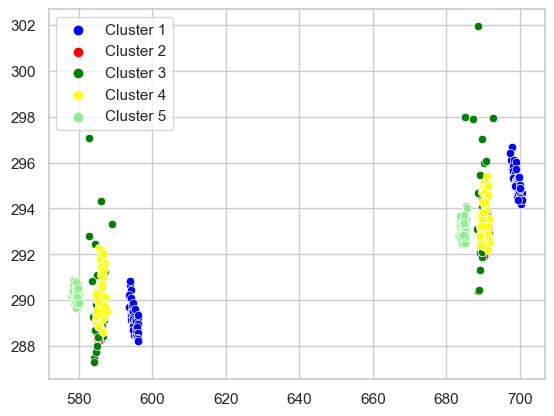

left only: fixed train


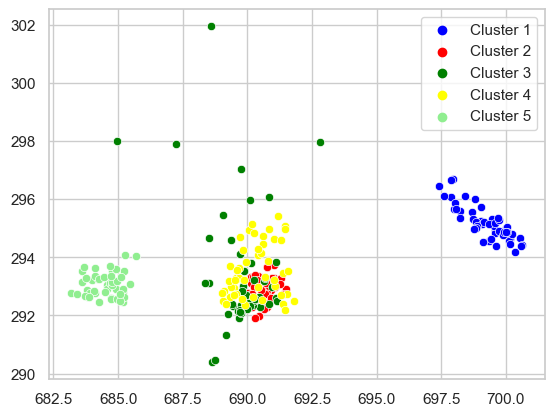

right only: fixed train


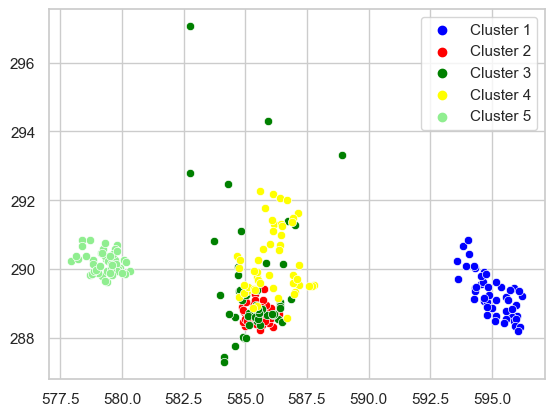

both eyes: predict train


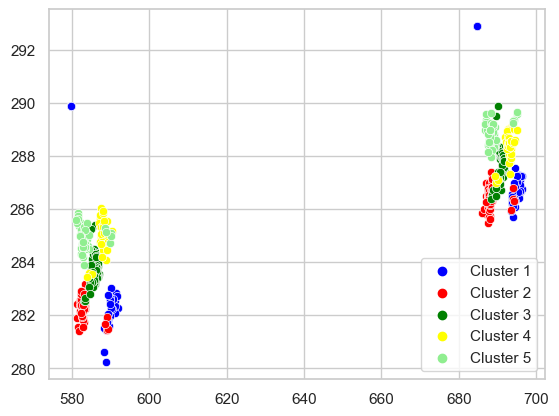

left only: predict train


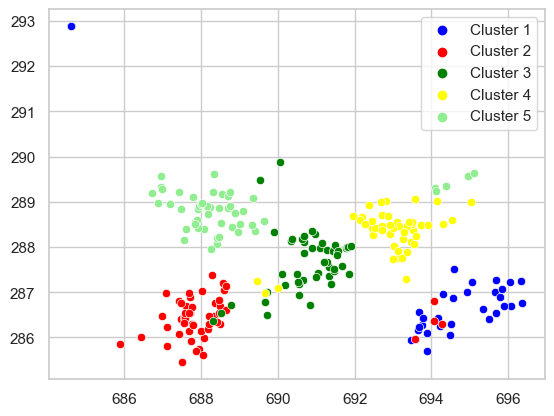

right only: predict train


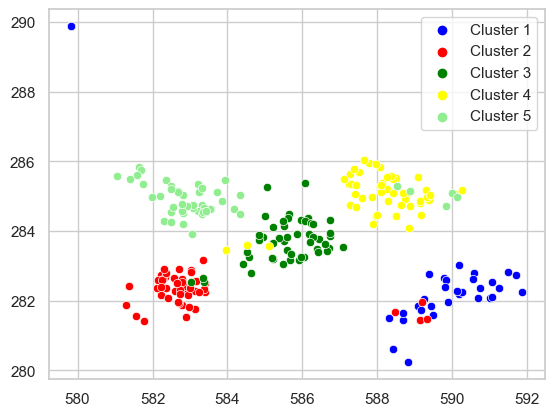

both eyes: cost


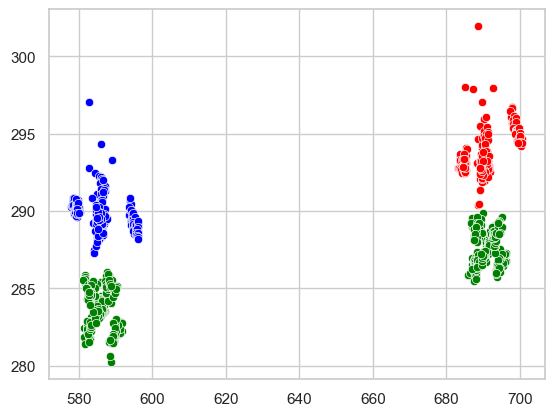

left only: cost


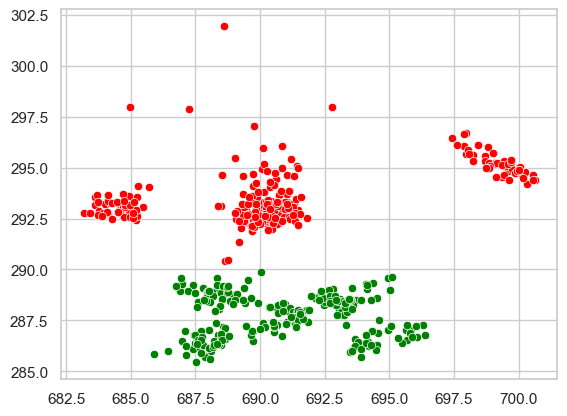

right only: cost


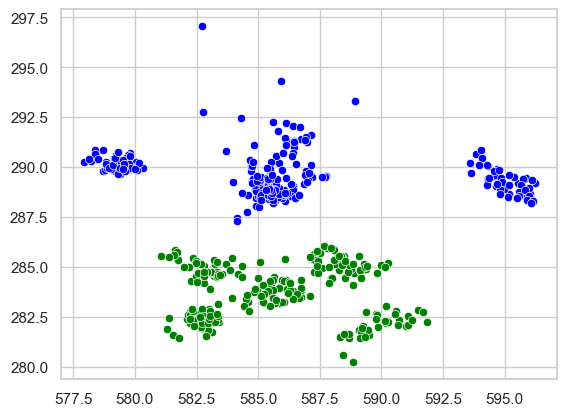

general prediction


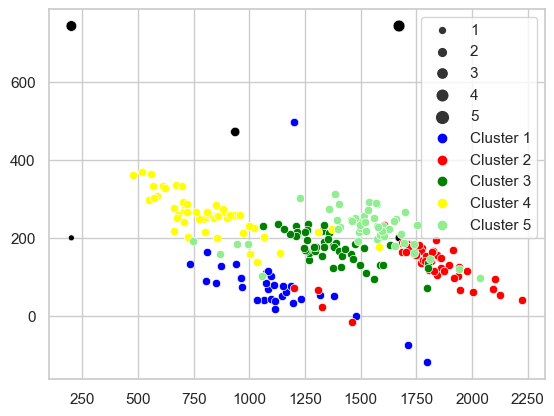

In [6]:
eye = EyeInfo(calib_points=calib_points, dataset=output)
eye.init_eye()
prediction_df = eye.prediction_df
fixed_train_df = pd.read_csv(train_input)
predict_train_df = pd.read_csv(predict_input)
if display_train_data:
    print('both eyes: fixed train')
    eye.plot(datasets= [fixed_train_df, fixed_train_df], keys_x=['left_iris_x', 'right_iris_x'], keys_y=['left_iris_y','right_iris_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_train_data)
    print('left only: fixed train')
    eye.plot(datasets= [fixed_train_df], keys_x=['left_iris_x'], keys_y=['left_iris_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_train_data)
    print('right only: fixed train')
    eye.plot(datasets= [fixed_train_df], keys_x=['right_iris_x'], keys_y=['right_iris_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_train_data)
if display_predict_data:
    print('both eyes: predict train')
    eye.plot(datasets= [predict_train_df, predict_train_df], keys_x=['left_iris_x', 'right_iris_x'], keys_y=['left_iris_y','right_iris_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_predict_data)
    print('left only: predict train')
    eye.plot(datasets= [predict_train_df], keys_x=['left_iris_x'], keys_y=['left_iris_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_predict_data)
    print('right only: predict train')
    eye.plot(datasets= [predict_train_df], keys_x=['right_iris_x'], keys_y=['right_iris_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_predict_data)
if display_cost:
    print('both eyes: cost')
    eye.plot(datasets= [predict_train_df,fixed_train_df, predict_train_df, fixed_train_df], keys_x=['left_iris_x','left_iris_x', 'right_iris_x', 'right_iris_x'], keys_y=['left_iris_y','left_iris_y','right_iris_y','right_iris_y'], is_subset=False, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_cost, colors=['green','red','green','blue'])
    print('left only: cost')
    eye.plot(datasets= [predict_train_df,fixed_train_df, ], keys_x=['left_iris_x','left_iris_x'], keys_y=['left_iris_y','left_iris_y'], is_subset=False, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_cost, colors=['green', 'red'])
    print('right only: cost')
    eye.plot(datasets= [predict_train_df,fixed_train_df, ], keys_x=['right_iris_x','right_iris_x'], keys_y=['right_iris_y','right_iris_y'], is_subset=False, subset_size=subset_size, lock_plot=lock_plot, eyes_only=display_cost, colors=['green', 'blue'])
if display_prediction:
    print('general prediction')
    eye.plot(datasets= [prediction_df], keys_x=['screen_x'], keys_y=['screen_y'], is_subset=is_subset, subset_size=subset_size, lock_plot=lock_plot, eyes_only=not display_prediction)